# MLP, CNN 이해

- MNIST 이미지 인식
- colab에서 실행

# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from keras.datasets import mnist
from keras.utils.np_utils import to_categorical
from keras import layers
from keras import models

# MNIST 데이터

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
train_images.shape

(60000, 28, 28)

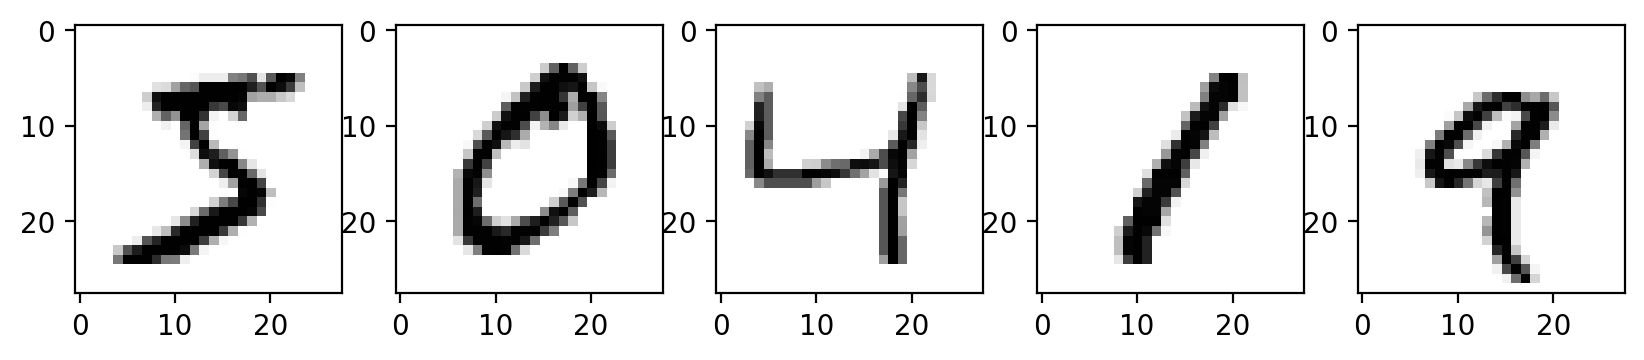

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i in range(5):
    axes[i].imshow(train_images[i], cmap=plt.cm.binary)
plt.show()

In [6]:
train_labels[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

## MLP 입력 전처리
- MLP는 1차원 텐서 즉 벡터만 입력으로 받는다 (일렬 횡대 입력)
- 목적 변수(여기서는 0~9 의 숫자)는 원 핫 인코딩을 해야 하며 케라스가 제공하는 to_categorical를 사용한다 (get_dummies와 같은 역할 수행)
- 입력값은 0~1 사이로 min-max 스케일링은 한다

In [7]:
X_train = train_images.reshape(60000, 28*28)
X_train = X_train.astype('float32')/255

X_test = test_images.reshape(10000, 28*28)
X_test = X_test.astype('float32')/255

y_train_cat = to_categorical(train_labels)
y_test_cat = to_categorical(test_labels)

In [8]:
print(X_train.shape)
y_train_cat[:3]

(60000, 784)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

# MLP 모델

- [MLP 동작 이해(playground)](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.30687&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)
- [MLP로 구현한 MNIST 인식 모델](https://www.kaggle.com/code/heeraldedhia/mnist-classifier-first-deep-learning-project/notebook)
- 출력단은 10개의 점수를 얻은 후에 소프트맥스를 수행하여 확률을 예측했다 - 10개의 클래스 확률을 얻었다

In [ ]:
model_m = models.Sequential()
model_m.add(layers.Dense(100, activation='relu', input_shape = (28*28,)))
model_m.add(layers.Dense(100, activation='relu'))
model_m.add(layers.Dense(10, activation='softmax'))
model_m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


## 조기 종료 조건
- 이포크 종료 조건을 keras.callbacks.EarlyStopping로 설정할 수 있다
- 아래는 총 이포크를 30회 진행하되 이포크가 3회 진행하는 동안 검증 데이터에 대해 정확도가 개선되지 않으면 종료하라는 뜻이다
 - 이 때 검증 데이터는 훈련 데이터중에 20%를 자체적으로 사용한다

In [ ]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# adam외에 다른 최적화 알고리즘으로 'rmsprop'도 널리 사용된다
# 레이블은 원 핫 인코딩을 사용해야 한다 (10개의 값을 각각 주어야 하므로)
h = model_m.fit(X_train,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
2400/2400 [==============================] - 15s 4ms/step - loss: 0.2540 - accuracy: 0.9236 - val_loss: 0.1266 - val_accuracy: 0.9634
Epoch 2/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.1089 - accuracy: 0.9669 - val_loss: 0.1035 - val_accuracy: 0.9695
Epoch 3/30
2400/2400 [==============================] - 12s 5ms/step - loss: 0.0760 - accuracy: 0.9768 - val_loss: 0.1096 - val_accuracy: 0.9669
Epoch 4/30
2400/2400 [==============================] - 11s 4ms/step - loss: 0.0586 - accuracy: 0.9810 - val_loss: 0.1020 - val_accuracy: 0.9704
Epoch 5/30
2400/2400 [==============================] - 8s 3ms/step - loss: 0.0458 - accuracy: 0.9852 - val_loss: 0.1090 - val_accuracy: 0.9722
Epoch 6/30
2400/2400 [==============================] - 13s 5ms/step - loss: 0.0389 - accuracy: 0.9870 - val_loss: 0.0978 - val_accuracy: 0.9733
Epoch 7/30
2400/2400 [==============================] - 10s 4ms/step - loss: 0.0312 - accuracy: 0.9896 - val_loss: 0.0967 - val_accu

## fit 함수
- 매 이포크마다 실행 결과를 history 타입의 객체에 저장한다
- 이 객체에 손실함수와 성능평가 기록이 남아 있다

In [9]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

In [10]:
show_4_graphs(h)

NameError: ignored

- 검증데이터에 대한 평가는 evaluate()로 수행한다

In [ ]:
test_loss, test_acc = model_m.evaluate(X_test, y_test_cat)
print('loss, acc = ',test_loss, test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.1172 - accuracy: 0.9752
loss, acc =  0.11722329258918762 0.9751999974250793


###  예측에 사용하기
- predict()함수를 호출하면 클래스 확률을 보여준다
- 10개의 클래스 확률중에 어떤 클래스의 확률이 가장 큰지는 agrmax()로 찾는다

In [ ]:
model_m.predict(X_train[0:3])

1/1 [==============================] - 0s 73ms/step


array([[9.3840004e-27, 4.7926670e-16, 1.6071808e-16, 1.3520035e-02,
        2.6808958e-23, 9.8647994e-01, 1.7811349e-21, 1.0856137e-20,
        2.5430653e-13, 2.6275809e-10],
       [1.0000000e+00, 4.4427419e-23, 3.5071335e-11, 1.7412460e-20,
        1.7186900e-20, 4.2378797e-19, 1.7449429e-13, 5.3873305e-18,
        4.4271626e-22, 2.3875767e-12],
       [3.1291595e-12, 1.0164287e-11, 3.1484267e-11, 1.3162475e-11,
        9.9999678e-01, 6.5109870e-13, 1.2172916e-09, 7.3693395e-12,
        2.9632097e-09, 3.2413027e-06]], dtype=float32)

In [ ]:
np.argmax(model_m.predict(X_train[0:5]), axis=1)

1/1 [==============================] - 0s 19ms/step


array([5, 0, 4, 1, 9])

# CNN 모델
- CNN은 입력으로 4차원 구조를 필요로 한다
 - (샘플수, 가로, 세로, 특성수)
- 구조를 맞추기 위해서 reshape를 사용한다
- [CNN 모델을 사용한 MNIST 인식](https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9)

In [11]:
X_train_cnn = train_images.reshape(-1,28,28,1)
X_test_cnn = test_images.reshape(-1,28,28,1)

In [14]:
from keras import layers
from keras import models

model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(32, (3,3), activation='relu', input_shape = (28, 28,1)))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Conv2D(64, (3,3), activation='relu'))
model_cnn.add(layers.Conv2D(64, (3,3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Flatten())
#model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

In [15]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# 다른 최적화 알고리즘 'rmsprop'
# 레이블로 원 핫 인코딩을 사용해야 한다
h = model_cnn.fit(X_train_cnn,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
2400/2400 [==============================] - 21s 4ms/step - loss: 0.2316 - accuracy: 0.9473 - val_loss: 0.0821 - val_accuracy: 0.9765
Epoch 2/30
2400/2400 [==============================] - 11s 4ms/step - loss: 0.0694 - accuracy: 0.9792 - val_loss: 0.0565 - val_accuracy: 0.9833
Epoch 3/30
2400/2400 [==============================] - 10s 4ms/step - loss: 0.0560 - accuracy: 0.9828 - val_loss: 0.0459 - val_accuracy: 0.9854
Epoch 4/30
2400/2400 [==============================] - 12s 5ms/step - loss: 0.0474 - accuracy: 0.9856 - val_loss: 0.0522 - val_accuracy: 0.9874
Epoch 5/30
2400/2400 [==============================] - 11s 5ms/step - loss: 0.0393 - accuracy: 0.9883 - val_loss: 0.0535 - val_accuracy: 0.9844
Epoch 6/30
2400/2400 [==============================] - 10s 4ms/step - loss: 0.0364 - accuracy: 0.9890 - val_loss: 0.0653 - val_accuracy: 0.9844
Epoch 7/30
2400/2400 [==============================] - 11s 4ms/step - loss: 0.0328 - accuracy: 0.9901 - val_loss: 0.0677 - val_ac

In [16]:
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test_cat)
print('test_acc = ',test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0576 - accuracy: 0.9859
test_acc =  0.9858999848365784


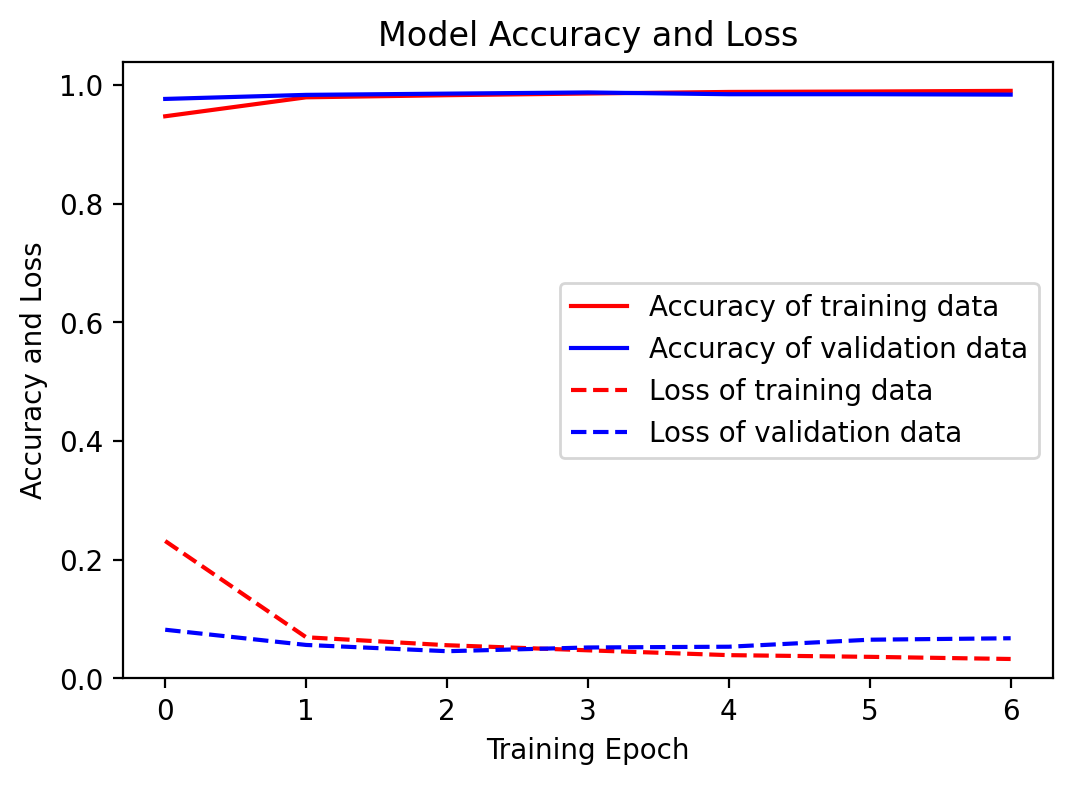

In [17]:
show_4_graphs(h)

# MLP를 이용한  회귀 예측
- 출력단을 다음과 같이 작성하면 회귀예측을 수행하는 모델을 학습한다 (softmax를 호출하면 분류 모델이다)
 - model.add(layers.Dense(1))
- 목적 변수 3개를 예측하는 경우
 - model.add(layers.Dense(3))

# (실습) 성능이 최대한 높게 나오도록 CNN 모델을 개선하시오


# (실습) 위에서 얻은 최고 성능의 95%를 달성하는 모델을 만들되 가능하면 간단한 모델, 즉, 파라미터수가 적을 모델을 만드시오

In [35]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(4, (3,3), activation='relu', input_shape = (28, 28,1)))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Conv2D(6, (3,3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(10, activation='softmax'))

model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 13, 13, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 11, 11, 6)         222       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 5, 5, 6)          0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 150)               0         
                                                                 
 dense_12 (Dense)            (None, 10)              

In [36]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# 다른 최적화 알고리즘 'rmsprop'
# 레이블로 원 핫 인코딩을 사용해야 한다
h = model_cnn.fit(X_train_cnn,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
2400/2400 [==============================] - 11s 4ms/step - loss: 0.9744 - accuracy: 0.7631 - val_loss: 0.2538 - val_accuracy: 0.9233
Epoch 2/30
2400/2400 [==============================] - 10s 4ms/step - loss: 0.2117 - accuracy: 0.9349 - val_loss: 0.1639 - val_accuracy: 0.9488
Epoch 3/30
2400/2400 [==============================] - 11s 4ms/step - loss: 0.1577 - accuracy: 0.9508 - val_loss: 0.1333 - val_accuracy: 0.9607
Epoch 4/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.1276 - accuracy: 0.9597 - val_loss: 0.1207 - val_accuracy: 0.9639
Epoch 5/30
2400/2400 [==============================] - 10s 4ms/step - loss: 0.1140 - accuracy: 0.9645 - val_loss: 0.1244 - val_accuracy: 0.9618
Epoch 6/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.1044 - accuracy: 0.9665 - val_loss: 0.1301 - val_accuracy: 0.9609
Epoch 7/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0973 - accuracy: 0.9691 - val_loss: 0.1051 - val_accur

In [37]:
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test_cat)
print('test_acc = ',test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0862 - accuracy: 0.9736
test_acc =  0.9735999703407288


In [29]:
model_cnn = models.Sequential()
model_cnn.add(layers.Conv2D(4, (3,3), activation='relu', input_shape = (28, 28,1)))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Conv2D(8, (3,3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2,2)))

model_cnn.add(layers.Flatten())
#model_cnn.add(layers.Dense(128, activation='relu'))
model_cnn.add(layers.Dense(10, activation='softmax'))

model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 26, 26, 4)         40        
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 11, 11, 8)         296       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 5, 8)          0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 200)               0         
                                                                 
 dense_10 (Dense)            (None, 10)               

In [30]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]

model_cnn.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
# 다른 최적화 알고리즘 'rmsprop'
# 레이블로 원 핫 인코딩을 사용해야 한다
h = model_cnn.fit(X_train_cnn,
                      y_train_cat,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
2400/2400 [==============================] - 12s 4ms/step - loss: 1.2324 - accuracy: 0.8464 - val_loss: 0.1795 - val_accuracy: 0.9463
Epoch 2/30
2400/2400 [==============================] - 10s 4ms/step - loss: 0.1584 - accuracy: 0.9520 - val_loss: 0.1153 - val_accuracy: 0.9639
Epoch 3/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.1140 - accuracy: 0.9663 - val_loss: 0.1005 - val_accuracy: 0.9697
Epoch 4/30
2400/2400 [==============================] - 10s 4ms/step - loss: 0.0975 - accuracy: 0.9701 - val_loss: 0.0871 - val_accuracy: 0.9744
Epoch 5/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0853 - accuracy: 0.9732 - val_loss: 0.0984 - val_accuracy: 0.9717
Epoch 6/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0765 - accuracy: 0.9760 - val_loss: 0.0822 - val_accuracy: 0.9774
Epoch 7/30
2400/2400 [==============================] - 9s 4ms/step - loss: 0.0712 - accuracy: 0.9780 - val_loss: 0.0988 - val_accura

In [31]:
test_loss, test_acc = model_cnn.evaluate(X_test_cnn, y_test_cat)
print('test_acc = ',test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0865 - accuracy: 0.9746
test_acc =  0.9746000170707703
